In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
import os
import pandas as pd
import scipy.ndimage as ndi
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
import seaborn as sns

# Load the T1 and T2 Flair image

In [43]:
img_path_T1 = '/content/drive/MyDrive/MAIA Work/Semester 3/MISA/Lab 2/P2_data/1/T1.nii'
img_path_T2 = '/content/drive/MyDrive/MAIA Work/Semester 3/MISA/Lab 2/P2_data/1/T2_FLAIR.nii'
img_data_T1 = nib.load(img_path_T1)
img_data_T2 = nib.load(img_path_T2)
img_T1 = img_data_T1.get_fdata()
img_T2 = img_data_T2.get_fdata()

# load the ground truth
gt_path = '/content/drive/MyDrive/MAIA Work/Semester 3/MISA/Lab 2/P2_data/1/LabelsForTesting.nii'
gt_data = nib.load(gt_path)
gt = gt_data.get_fdata()

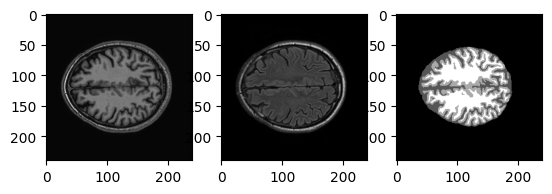

In [44]:
# Visualize the image

plt.subplot(1,3,1)
plt.imshow(img_T1[:,:,30], cmap='gray')
plt.subplot(1,3,2)
plt.imshow(img_T2[:,:,30], cmap='gray')
plt.subplot(1,3,3)
plt.imshow(gt[:,:,30], cmap='gray')
plt.show()

In [45]:
y_T1 = img_T1[gt > 0]
y_T2 = img_T2[gt > 0]

print(type(y_T1))
print(y_T2.shape)

<class 'numpy.ndarray'>
(456532,)


In [46]:
# # Create a scatterplot with seaborn
# plt.figure(figsize=(15, 15))
# sns.scatterplot(x=y_T1, y=y_T2, marker='o')

# # Optionally, you can add a kernel density estimate for better understanding of the density
# sns.kdeplot(x=y_T1, y=y_T2, cmap="Blues", shade=True, thresh=0.05)

# plt.show()

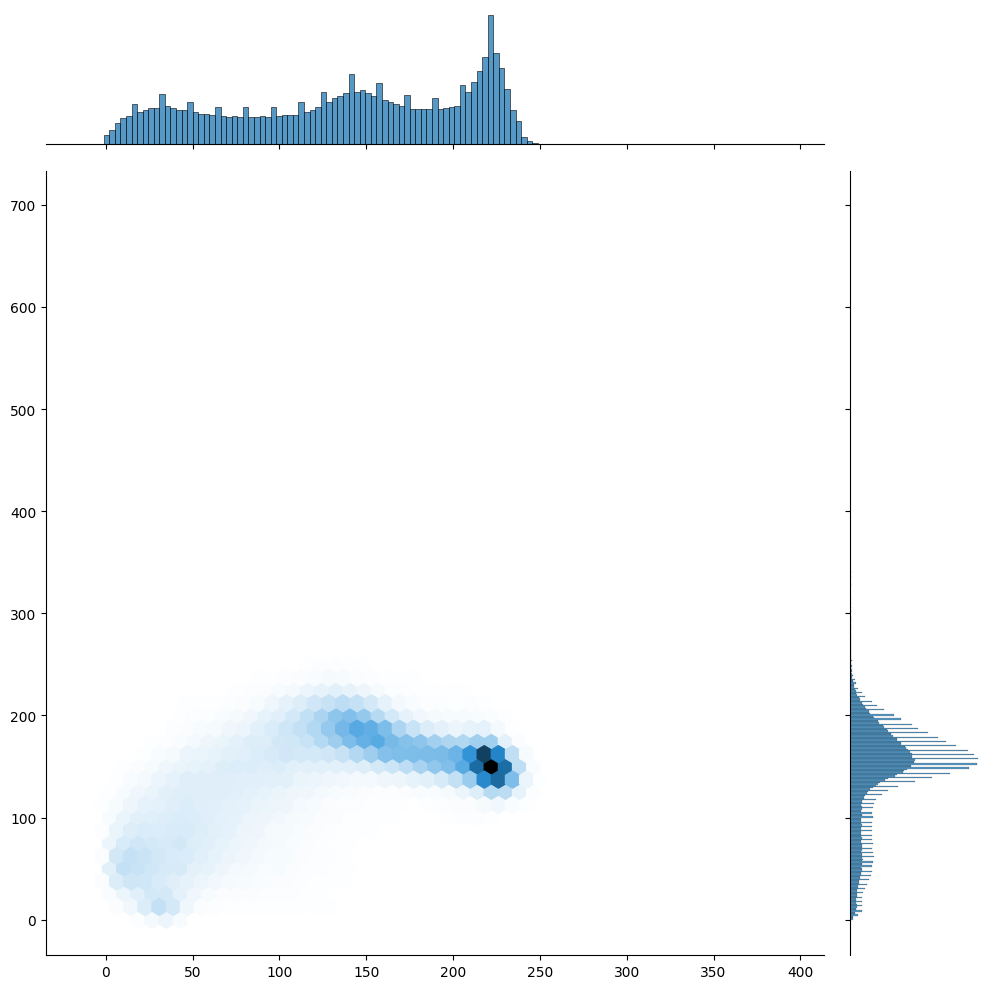

In [47]:
sns.jointplot(x=y_T1, y=y_T2, kind="hex", height=10)
plt.show()

# Initialize the parameters for EM algorithm

In [48]:
# Stack them into a 2D array for clustering.
data = np.array([y_T1, y_T2]).T
print(data.shape)

kmeans = KMeans(n_clusters=3, random_state=0).fit(data)
mu = kmeans.cluster_centers_

labels = kmeans.labels_

sigma = []

# Compute the standard deviation for each cluster
for i in range(3):
    cluster_points = data[labels == i]
    cluster_std = np.std(cluster_points, axis=0)
    sigma.append(cluster_std)

sigma = np.array(sigma)

# Set pi to 1/3 as we have three clusters
pi = [1/3, 1/3, 1/3]

print("mu (cluster centers):")
print(mu)

print("sigma (cluster standard deviations):")
print(sigma)

print("pi (mixing coefficient):")
print(pi)

(456532, 2)
mu (cluster centers):
[[ 46.34921024  76.1434844 ]
 [207.82934343 154.23819268]
 [126.33736538 181.06546395]]
sigma (cluster standard deviations):
[[29.14980902 38.00298277]
 [19.84534824 18.19394463]
 [29.9563331  27.61632384]]
pi (mixing coefficient):
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]


In [52]:
# Function to calculate the multivariate Gaussian probability density function
def gaussian_pdf(x, mu, cov):
    k = len(mu)  # Dimensionality of the data
    cov_inv = np.linalg.inv(cov)  # Inverse of the covariance matrix
    cov_det = np.linalg.det(cov)  # Determinant of the covariance matrix

    # Normalization factor (1 / sqrt((2 * pi)^k * det(cov)))
    norm_factor = 1 / np.sqrt((2 * np.pi) ** k * cov_det)

    # Compute the difference between x and mu for each data point
    diff = x - mu

    # Apply Gaussian PDF for each data point: (x - mu)^T * cov_inv * (x - mu)
    # This requires using a loop or vectorized broadcasting
    exp_term = np.einsum('ij,jk,ik->i', diff, cov_inv, diff)  # Efficient matrix multiplication for each sample

    # Return the Gaussian probability for each data point
    return norm_factor * np.exp(-0.5 * exp_term)

In [11]:
# # Function to calculate the Gaussian probability
# def gaussian_pdf(x, mu, cov):
#     return multivariate_normal.pdf(x, mean=mu, cov=cov)

In [53]:
# Expectation-Maximization (EM) algorithm
def em_algorithm(data, mu, sigma, pi, max_iter=100, tol=1e-6):

    n_samples, n_features = data.shape
    n_clusters = mu.shape[0]

    # Initialize the responsibilities matrix (E-step)
    responsibilities = np.zeros((n_samples, n_clusters))

    log_likelihoods = []

    for iter in range(max_iter):
      ### E-Step: Compute the responsibilities
      for i in range(n_clusters):
          responsibilities[:, i] = pi[i] * gaussian_pdf(data, mu[i], np.diag(sigma[i]**2))

      # Normalize responsibilities for each data point
      responsibilities /= np.sum(responsibilities, axis=1, keepdims=True)

      ### M-Step: Update parameters (mu, sigma, pi)
      N_k = responsibilities.sum(axis=0)  # Total responsibility assigned to each cluster

      # Update mu (means)
      for i in range(n_clusters):
          mu[i] = (responsibilities[:, i].reshape(-1, 1) * data).sum(axis=0) / N_k[i]

      # Update sigma (standard deviations)
      for i in range(n_clusters):
            diff = data - mu[i]
            sigma[i] = np.sqrt((responsibilities[:, i].reshape(-1, 1) * diff**2).sum(axis=0) / N_k[i])

      # Update pi (mixing coefficients)
      pi = N_k / n_samples

      ### Compute the log likelihood for convergence check
      log_likelihood = np.sum(np.log(np.sum([pi[k] * gaussian_pdf(data, mu[k], np.diag(sigma[k]**2))
                                               for k in range(n_clusters)], axis=0)))
      log_likelihoods.append(log_likelihood)

      # Check for convergence
      if iter > 0 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
          break

    return mu, sigma, pi, log_likelihoods, responsibilities

In [54]:
# Assuming y_T1 and y_T2 are defined and represent your data for T1 and T2 respectively.
data = np.array([y_T1, y_T2]).T

# KMeans initialization for mu, sigma, and pi
kmeans = KMeans(n_clusters=3, random_state=0).fit(data)
mu = kmeans.cluster_centers_

# Manually calculate sigma as before
labels = kmeans.labels_
sigma = np.zeros_like(mu)
for i in range(3):
    cluster_points = data[labels == i]
    sigma[i] = np.std(cluster_points, axis=0)

# Initialize pi to 1/3 for each cluster
pi = np.ones(3) / 3

# Run the EM algorithm
mu, sigma, pi, log_likelihoods, responsibilities = em_algorithm(data, mu, sigma, pi)

# Output final parameters
print("Final mu (cluster means):")
print(mu)
print("Final sigma (cluster standard deviations):")
print(sigma)
print("Final pi (mixing coefficients):")
print(pi)

Final mu (cluster means):
[[ 51.08791742  88.3020017 ]
 [217.96511681 150.19974618]
 [146.69763414 177.52747141]]
Final sigma (cluster standard deviations):
[[31.57175181 50.32878884]
 [11.77306646 13.69326588]
 [32.96038    24.37543254]]
Final pi (mixing coefficients):
[0.29940291 0.26115373 0.43944336]


In [55]:
responsibilities.shape

(456532, 3)

In [56]:
# To generate the labels, take the argmax along axis 1
labels = np.argmax(responsibilities, axis=1)+1

In [57]:
np.unique(labels)
label3d = np.zeros_like(gt)
label3d[gt > 0] = labels

In [58]:
# Let's create a mapping to swap the labels
label_mapping = {0: 0, 1: 1, 2: 3, 3: 2}

# Apply the label mapping to your segmentation labels
# `segmentation_labels` is assumed to be the array of labels obtained from the EM algorithm
new_labels = np.vectorize(label_mapping.get)(label3d)

In [59]:
def dice_score(pred, true, label):
    """
    Calculate the Dice similarity coefficient for a specific label.

    Args:
        pred (ndarray): Predicted segmentation mask.
        true (ndarray): Ground truth mask.
        label (int): Label for which to calculate the Dice score.

    Returns:
        float: Dice similarity coefficient.
    """
    pred_mask = (pred == label)
    true_mask = (true == label)

    intersection = np.sum(pred_mask & true_mask)
    pred_sum = np.sum(pred_mask)
    true_sum = np.sum(true_mask)

    if pred_sum + true_sum == 0:
        return 1.0  # Avoid division by zero if both are empty
    return (2.0 * intersection) / (pred_sum + true_sum)


In [60]:
dice_scores = {}
for label in range(4):
    dice_scores[label] = dice_score(new_labels, gt, label)
    print(f"T1 Dice score for label {label}: {dice_scores[label]}")


T1 Dice score for label 0: 1.0
T1 Dice score for label 1: 0.8731934934076893
T1 Dice score for label 2: 0.8057763747476461
T1 Dice score for label 3: 0.8618861708527294


In [61]:
def process_em_for_folder(input_dir, output_dir):
    """
    Function to apply the Expectation-Maximization (EM) algorithm to MRI data (T1, T2_FLAIR) in a folder.
    It calculates the segmentation for GM, WM, CSF, and Background for both T1 and T2_FLAIR modalities.

    Args:
        input_dir (str): Path to the folder containing T1 and T2_FLAIR files.
        output_dir (str): Path to the folder where the resulting segmentation NIfTI file will be saved.

    Returns:
        dict: Dictionary containing results of EM algorithm and Dice scores for T1 and T2_FLAIR.
    """
    # File paths for T1, FLAIR, and ground truth (GT) modalities
    t1_file = os.path.join(input_dir, 'T1.nii')
    flair_file = os.path.join(input_dir, 'T2_FLAIR.nii')
    gt_file = os.path.join(input_dir, 'LabelsForTesting.nii')

    # Load the T1, FLAIR, and GT images
    t1_img = nib.load(t1_file)
    flair_img = nib.load(flair_file)
    gt_img = nib.load(gt_file)

    t1_data = t1_img.get_fdata()
    flair_data = flair_img.get_fdata()
    gt_data = gt_img.get_fdata()

    # Normalize the data to ensure consistent intensity range across folders
    t1_data = (t1_data - np.mean(t1_data)) / np.std(t1_data)
    flair_data = (flair_data - np.mean(flair_data)) / np.std(flair_data)

    # Use only the non-background pixels from the ground truth (gt_data > 0)
    y_T1 = t1_data[gt_data > 0]
    y_T2 = flair_data[gt_data > 0]

    # Combine the T1 and FLAIR data for EM clustering
    data = np.array([y_T1, y_T2]).T

    # KMeans initialization with multiple runs to ensure better clustering
    kmeans = KMeans(n_clusters=3, random_state=0, n_init=10).fit(data)
    mu = kmeans.cluster_centers_

    # Calculate sigma for each cluster
    labels = kmeans.labels_
    sigma = np.zeros_like(mu)
    for i in range(3):
        cluster_points = data[labels == i]
        sigma[i] = np.std(cluster_points, axis=0)

    # Initialize pi (mixing coefficients) to 1/3 for each cluster
    pi = np.ones(3) / 3

    # Run the EM algorithm
    mu, sigma, pi, log_likelihoods, responsibilities = em_algorithm(data, mu, sigma, pi)

    # Sort the clusters based on the intensity (mu) values
    sorted_indices = np.argsort(mu[:, 0])  # Sort based on the first dimension (T1)
    # Map the sorted indices to CSF, GM, and WM labels
    label_mapping = {sorted_indices[0]: 1, sorted_indices[1]: 2, sorted_indices[2]: 3}  # 1: CSF, 2: GM, 3: WM

    # Generate labels from responsibilities and map them (1-based)
    labels = np.argmax(responsibilities, axis=1)
    mapped_labels = np.vectorize(label_mapping.get)(labels)  # Apply the label mapping

    # Reshape the labels back to the original 3D shape
    label3d = np.zeros_like(gt_data)
    label3d[gt_data > 0] = mapped_labels

    # Convert to int32 to avoid type incompatibilities
    new_labels = label3d.astype(np.int32)

    # Save the segmentation mask as a NIfTI file
    segmentation_img = nib.Nifti1Image(new_labels, affine=t1_img.affine)
    output_file = os.path.join(output_dir, 'segmentation_mask.nii')
    nib.save(segmentation_img, output_file)
    print(f"Segmentation mask saved at {output_file}")

    # Calculate Dice scores for each label (1: CSF, 2: GM, 3: WM)
    dice_scores = {}
    for label in range(1, 4):  # Skip background (0)
        dice_scores[label] = dice_score(new_labels, gt_data, label)
        print(f"Dice score for label {label}: {dice_scores[label]}")

    # Return the EM results and Dice scores
    return {
        'mu': mu,
        'sigma': sigma,
        'dice_scores': dice_scores  # Store the dice scores for each label (CSF, GM, WM)
    }


def process_all_folders_with_em(parent_directory, output_parent_directory):
    """
    Function to loop through all subdirectories, apply the EM algorithm, and save the segmentation results.

    Args:
        parent_directory (str): Path to the directory containing subdirectories with the MRI files.
        output_parent_directory (str): Path to the directory where processed segmentation masks will be saved.

    Returns:
        dict: Dictionary containing EM results for all folders.
    """
    all_em_results = {}

    # Loop over all folders in the parent directory
    for folder_name in os.listdir(parent_directory):
        input_dir = os.path.join(parent_directory, folder_name)

        if os.path.isdir(input_dir):
            output_dir = os.path.join(output_parent_directory, folder_name)
            os.makedirs(output_dir, exist_ok=True)

            try:
                # Process the folder and get EM results
                em_results = process_em_for_folder(input_dir, output_dir)

                # Store EM results for each folder
                all_em_results[folder_name] = em_results
                print(f"Processed folder: {folder_name} | EM Results: {em_results}")

            except Exception as e:
                print(f"Error processing folder {folder_name}: {str(e)}")

    return all_em_results

def create_dice_table(em_results):
    """
    Create a pandas DataFrame summarizing the Dice scores (mean and std) for CSF, GM, and WM for each folder.

    Args:
        em_results (dict): Dictionary containing the EM and Dice score results for each folder.

    Returns:
        pd.DataFrame: A DataFrame summarizing the mean and std Dice scores for CSF, GM, and WM.
    """
    rows = []

    # Loop through each folder and get the dice scores
    for folder, results in em_results.items():
        # Extract the Dice scores for CSF, GM, and WM (labels 1, 2, 3)
        csf_dice = results['dice_scores'][1]
        gm_dice = results['dice_scores'][2]
        wm_dice = results['dice_scores'][3]

        # Compute the mean and std Dice scores
        dice_values = np.array([csf_dice, gm_dice, wm_dice])
        dice_mean = np.mean(dice_values)
        dice_std = np.std(dice_values)

        row = {
            'Folder': folder,
            'CSF Dice': csf_dice,
            'GM Dice': gm_dice,
            'WM Dice': wm_dice,
            'Mean Dice': dice_mean,
            'Std Dice': dice_std
        }
        rows.append(row)

    # Create a DataFrame
    df = pd.DataFrame(rows)

    return df


In [21]:
# Parent directory where folders with T1 and T2_FLAIR are located
parent_directory = '/content/drive/MyDrive/MAIA Work/Semester 3/MISA/Lab 2/P2_data'
output_parent_directory = '/content/drive/MyDrive/MAIA Work/Semester 3/MISA/Lab 1/P2_data'

# Process all folders with the EM algorithm
all_em_results = process_all_folders_with_em(parent_directory, output_parent_directory)

# Create a summary table of Dice scores (mean and std)
dice_table = create_dice_table(all_em_results)
dice_table

Segmentation mask saved at /content/drive/MyDrive/MAIA Work/Semester 3/MISA/Lab 1/P2_data/5/segmentation_mask.nii
Dice score for label 1: 0.8850535009748384
Dice score for label 2: 0.865689385731954
Dice score for label 3: 0.8932353724922913
Processed folder: 5 | EM Results: {'mu': array([[ 1.03188891,  0.92679367],
       [-0.00243074,  0.15920254],
       [ 1.86600987,  0.71019596]]), 'sigma': array([[0.34077648, 0.18782903],
       [0.40981904, 0.41704907],
       [0.14329178, 0.12715645]]), 'dice_scores': {1: 0.8850535009748384, 2: 0.865689385731954, 3: 0.8932353724922913}}
Segmentation mask saved at /content/drive/MyDrive/MAIA Work/Semester 3/MISA/Lab 1/P2_data/3/segmentation_mask.nii
Dice score for label 1: 0.8564175304600836
Dice score for label 2: 0.7884713840440347
Dice score for label 3: 0.8243060134044679
Processed folder: 3 | EM Results: {'mu': array([[1.1862364 , 0.7990384 ],
       [0.04178416, 0.20304041],
       [1.91683918, 0.71234387]]), 'sigma': array([[0.39163143, 0

,Folder,CSF Dice,GM Dice,WM Dice,Mean Dice,Std Dice
0,5,0.885054,0.865689,0.893235,0.881326,0.011550
1,3,0.856418,0.788471,0.824306,0.823065,0.027753
2,4,0.855897,0.817770,0.862687,0.845452,0.019769
3,2,0.808290,0.240015,0.538951,0.529085,0.232102
4,1,0.873193,0.805776,0.861886,0.846952,0.029479


## Testing EM using only T1 image for Folder 2 which has a low dice score

In [65]:
img_path_T1_F2 = '/content/drive/MyDrive/MAIA Work/Semester 3/MISA/Lab 2/P2_data/2/T1.nii'

img_data_T1_F2 = nib.load(img_path_T1_F2)

img_T1_F2 = img_data_T1_F2.get_fdata()


# load the ground truth
gt_path_F2 = '/content/drive/MyDrive/MAIA Work/Semester 3/MISA/Lab 2/P2_data/2/LabelsForTesting.nii'
gt_data_F2 = nib.load(gt_path_F2)
gt_F2 = gt_data_F2.get_fdata()

In [66]:
y_T1_F2 = img_T1_F2[gt_F2 > 0]

print(type(y_T1_F2))
print(y_T1_F2.shape)

<class 'numpy.ndarray'>
(502089,)


In [67]:
# Stack them into a 2D array for clustering.
data_F2 = np.array([y_T1_F2]).T
print(data_F2.shape)

kmeans = KMeans(n_clusters=3, random_state=0).fit(data_F2)
mu_F2 = kmeans.cluster_centers_

labels = kmeans.labels_

sigma_F2 = []

# Compute the standard deviation for each cluster
for i in range(3):
    cluster_points = data_F2[labels == i]
    cluster_std = np.std(cluster_points, axis=0)
    sigma_F2.append(cluster_std)

sigma_F2 = np.array(sigma_F2)

# Set pi to 1/3 as we have three clusters
pi_F2 = [1/3, 1/3, 1/3]

print("mu (cluster centers):")
print(mu_F2)

print("sigma (cluster standard deviations):")
print(sigma_F2)

print("pi (mixing coefficient):")
print(pi_F2)

(502089, 1)
mu (cluster centers):
[[122.08826678]
 [ 43.93668832]
 [178.48172463]]
sigma (cluster standard deviations):
[[18.07892956]
 [21.7163549 ]
 [15.09850773]]
pi (mixing coefficient):
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]


In [72]:
mu_F2, sigma_F2, pi_F2, log_likelihoods_F2, responsibilities_F2 = em_algorithm(data_F2, mu_F2, sigma_F2, pi_F2)

In [73]:
responsibilities_F2.shape

(502089, 3)

In [75]:
# Sort the clusters based on the intensity (mu) values
sorted_indices_F2 = np.argsort(mu_F2[:, 0])  # Sort based on the first dimension (T1)
# Map the sorted indices to CSF, GM, and WM labels
label_mapping_F2 = {sorted_indices_F2[0]: 1, sorted_indices_F2[1]: 2, sorted_indices_F2[2]: 3}  # 1: CSF, 2: GM, 3: WM

# Generate labels from responsibilities and map them (1-based)
labels_F2 = np.argmax(responsibilities_F2, axis=1)
mapped_labels_F2 = np.vectorize(label_mapping_F2.get)(labels_F2)  # Apply the label mapping

# Reshape the labels back to the original 3D shape
label3d_F2 = np.zeros_like(gt_F2)
label3d_F2[gt_F2 > 0] = mapped_labels_F2

# Convert to int32 to avoid type incompatibilities
new_labels = label3d_F2.astype(np.int32)

In [76]:
dice_scores = {}
for label in range(4):
    dice_scores[label] = dice_score(new_labels, gt_F2, label)
    print(f"T1 Dice score for label {label}: {dice_scores[label]}")

T1 Dice score for label 0: 1.0
T1 Dice score for label 1: 0.8525510691429117
T1 Dice score for label 2: 0.8024256824074835
T1 Dice score for label 3: 0.7742590766548311
